In [1]:
import random
import numpy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler

In [2]:
import matplotlib.pyplot as plt
import os 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
%matplotlib inline

In [4]:
CONTEXT = 8

In [5]:
f = open('names.txt', 'r', encoding='utf-8')
names = f.read().split("\n")
f.close()

names = ["."*CONTEXT + name + "." for name in names]
names[:5]

['........emma.',
 '........olivia.',
 '........ava.',
 '........isabella.',
 '........sophia.']

In [6]:
CHARS = sorted(list(set("".join(names))))
"".join(CHARS)

'.abcdefghijklmnopqrstuvwxyz'

In [7]:
stoi = {ch: i for i, ch in enumerate(CHARS)}
itos = {i: ch for i, ch in enumerate(CHARS)}

text = ".hello.world."
"".join([itos[i] for i in [stoi[ch] for ch in text]])

'.hello.world.'

In [8]:
class NameDataset(Dataset):
    def __init__(self, names):
        self.x = []
        self.y = []
        for name in names:
            for i in range(CONTEXT, len(name)):
                self.x.append([stoi[ch] for ch in name[i-CONTEXT:i]])
                self.y.append(stoi[name[i]])
        self.x = torch.tensor(self.x)
        self.y = torch.tensor(self.y)
        self.x = F.one_hot(self.x, num_classes=len(CHARS)).float()
        
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

In [9]:
class MLP(nn.Module):
    def __init__(self, num_features=5, num_hidden=[100]):
        super().__init__()
        self.encoder = nn.Linear(len(CHARS), num_features)
        self.num_hidden = [num_features * CONTEXT] + num_hidden
        self.hidden_layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        for i in range(len(self.num_hidden) - 1):
            hidden_layer = nn.Linear(self.num_hidden[i], self.num_hidden[i + 1])
            with torch.no_grad():
                hidden_layer.weight.mul_(5/3)
            self.hidden_layers.append(hidden_layer)
            self.batch_norms.append(nn.BatchNorm1d(self.num_hidden[i + 1]))

        self.output_layer = nn.Linear(self.num_hidden[-1], len(CHARS))

        self.activations = {}  # store forward activations
        self.gradients = {}    # store backward gradients
        self.register_hooks()  # register hooks for histogram analysis

    def forward(self, x):
        output = self.encoder(x)
        output = output.view(-1, self.num_hidden[0])
        for i in range(len(self.hidden_layers)):
            output = self.hidden_layers[i](output)
            output = self.batch_norms[i](output)
            output = torch.tanh(output)
        logits = self.output_layer(output)
        return logits

    def register_hooks(self):
        def save_activation(name):
            def hook_fn(module, act_input, output):
                self.activations[name] = output.detach()
            return hook_fn

        def save_gradient(name):
            def hook_fn(module, grad_input, grad_output):
                self.gradients[name] = grad_output[0].detach()
            return hook_fn

        for i, layer in enumerate(self.hidden_layers):
            layer.register_forward_hook(save_activation(f'layer_{i}'))
            layer.register_full_backward_hook(save_gradient(f'layer_{i}'))  # backward of output w.r.t loss


In [10]:
def train(model, loader, steps=1000, lr=1e-1, alpha=1e-4):
    model.to("cuda")
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    losses = []
    for i in range(steps):
        for x, y in loader:
            x, y = x.to("cuda"), y.to("cuda")
            logits = model(x)
            loss = criterion(logits, y)
            loss += alpha*sum([(p**2).sum() for p in model.parameters()])
            losses.append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return losses

In [11]:
def validate(model, loader, stop=None):
    model.to("cuda")
    model.eval()
    criterion = nn.CrossEntropyLoss()
    losses = []
    with torch.no_grad():
        count = 0
        for x, y in loader:
            x, y = x.to("cuda"), y.to("cuda")
            logits = model(x)
            loss = criterion(logits, y)
            losses.append(loss.item())
            count += 1
            if stop != None and stop >= count:
                break
    return losses

In [12]:
def makemore(model):
    output = []
    model.to("cuda")
    model.eval()
    x_ch = ["."] * CONTEXT
    with torch.no_grad():
        while True:
            x = torch.tensor([stoi[ch] for ch in x_ch])
            x = F.one_hot(x, num_classes=len(CHARS)).float()
            x = x.to("cuda")
            logits = model(x)
            probs = F.softmax(logits, dim=-1)
            y = itos[torch.multinomial(probs, num_samples=1, replacement=True).item()]
            if y == ".":
                break
            output.append(y)
            x_ch = x_ch[1:] + [y]
    return "".join(output)

In [13]:
def plot_activation_and_gradient_stats(model):
    num_layers = len(model.activations)
    fig, axes = plt.subplots(2, num_layers, figsize=(4 * num_layers, 6), sharey='row')

    for i, name in enumerate(model.activations):
        act = model.activations[name].cpu()
        grad = model.gradients.get(name)
        if grad is not None:
            grad = grad.cpu()

        # Activation histogram (top row)
        hy, hx = torch.histogram(act, bins=100, density=True)
        axes[0, i].plot(hx[:-1], hy)
        axes[0, i].set_title(f'{name} - Activation')
        mean = act.mean().item()
        std = act.std().item()
        sat = (act.abs() > 0.97).float().mean().item() * 100
        print(f"{name} activation: mean={mean:+.3f}, std={std:.3f}, saturation={sat:.2f}%")

        # Gradient histogram (bottom row)
        if grad is not None:
            hy, hx = torch.histogram(grad, bins=100, density=True)
            axes[1, i].plot(hx[:-1], hy)
            axes[1, i].set_title(f'{name} - Gradient')
            mean = grad.mean().item()
            std = grad.std().item()
            print(f"{name} gradient: mean={mean:+.3f}, std={std:.3f}")

    axes[0, 0].set_ylabel("Activation Density")
    axes[1, 0].set_ylabel("Gradient Density")
#     plt.tight_layout()
    plt.show()


In [14]:
BATCH_SIZE = 256

split = int(len(names)*0.9)
random.seed(42)
random.shuffle(names)
train_data = NameDataset(names[:split])
val_data = NameDataset(names[split:])
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=RandomSampler(train_data, replacement=True, num_samples=BATCH_SIZE))
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
len(train_loader), len(val_loader)

(1, 90)

In [19]:
stats = []
model = MLP(num_features=15, num_hidden=[200, 200])
sum(p.numel() for p in model.parameters())

71047

In [20]:
print(f"Training...")
for epoch in range(500):
    lr = 2.0
    losses = train(model, train_loader, steps=100, lr=10**(-lr), alpha=1e-5)
    loss = sum(losses)/len(losses)
    stats.append(loss)
    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch+1}, Learning Rate: {lr}, Loss: {loss:.4f}")

print(f"Validating...")
losses = validate(model, val_loader)
print(f"Loss: {sum(losses)/len(losses)}")

Training...
Epoch: 10, Learning Rate: 2.0, Loss: 2.4298
Epoch: 20, Learning Rate: 2.0, Loss: 2.3348
Epoch: 30, Learning Rate: 2.0, Loss: 2.2928
Epoch: 40, Learning Rate: 2.0, Loss: 2.2501
Epoch: 50, Learning Rate: 2.0, Loss: 2.2280
Epoch: 60, Learning Rate: 2.0, Loss: 2.2045
Epoch: 70, Learning Rate: 2.0, Loss: 2.2041
Epoch: 80, Learning Rate: 2.0, Loss: 2.1802
Epoch: 90, Learning Rate: 2.0, Loss: 2.1716
Epoch: 100, Learning Rate: 2.0, Loss: 2.1643
Epoch: 110, Learning Rate: 2.0, Loss: 2.1382
Epoch: 120, Learning Rate: 2.0, Loss: 2.1246
Epoch: 130, Learning Rate: 2.0, Loss: 2.1311
Epoch: 140, Learning Rate: 2.0, Loss: 2.1266
Epoch: 150, Learning Rate: 2.0, Loss: 2.1199
Epoch: 160, Learning Rate: 2.0, Loss: 2.1148
Epoch: 170, Learning Rate: 2.0, Loss: 2.1034
Epoch: 180, Learning Rate: 2.0, Loss: 2.1134
Epoch: 190, Learning Rate: 2.0, Loss: 2.0999
Epoch: 200, Learning Rate: 2.0, Loss: 2.0874
Epoch: 210, Learning Rate: 2.0, Loss: 2.0885
Epoch: 220, Learning Rate: 2.0, Loss: 2.0817
Epoch: 

In [21]:
for i in range(10):
    new_name = makemore(model)
    if ("."*CONTEXT + new_name + ".") in names:
        print(f"old: {new_name}")
    else:
        print(f"new: {new_name}")

new: yanav
new: deonam
new: erjorc
new: zyian
new: nunae
new: camran
new: coriya
new: evelle
new: kbarti
old: ondre


layer_0 activation: mean=-0.022, std=0.164, saturation=0.00%
layer_0 gradient: mean=-0.000, std=0.001
layer_1 activation: mean=-0.001, std=0.636, saturation=12.68%
layer_1 gradient: mean=-0.000, std=0.000


<Figure size 0x600 with 0 Axes>

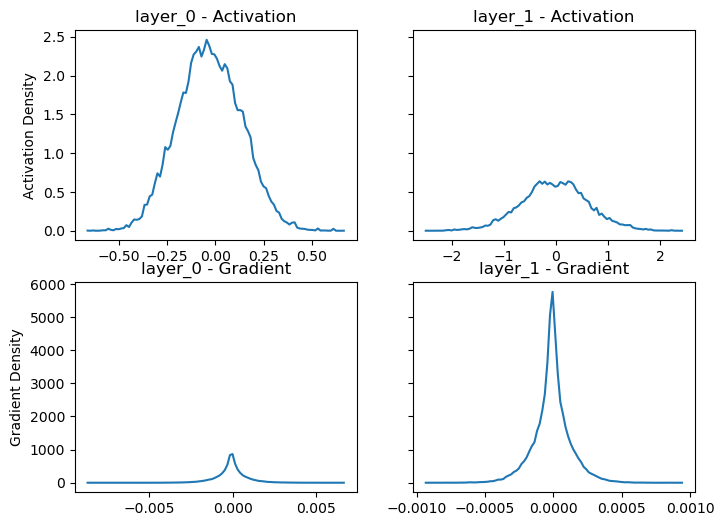

In [23]:
plot_activation_and_gradient_stats(model)

In [17]:
log_stats = []
for stat in stats:
    log_stats.append(numpy.log10(stat))
    
len(log_stats)

1000

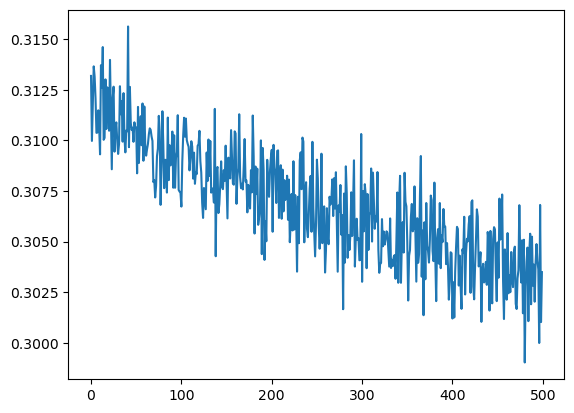

In [18]:
plt.plot(log_stats[500:])
# plt.plot(stats[500:])
plt.show()

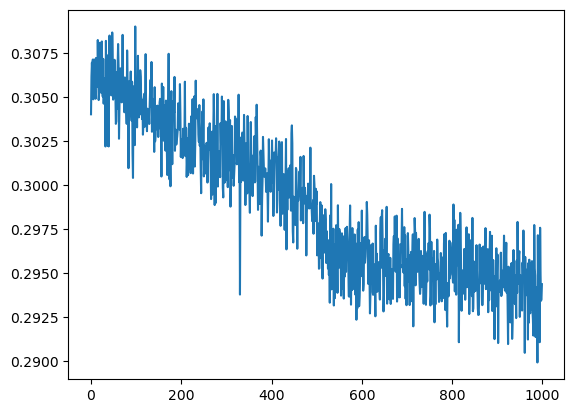

In [31]:
plt.plot(log_stats[500:])
# plt.plot(stats[500:])
plt.show()

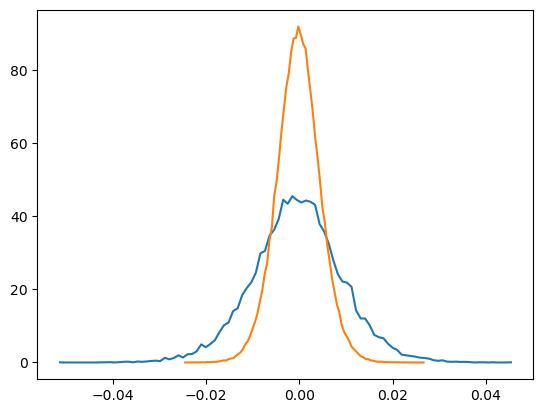

In [22]:
t = model.hidden_layers[0].weight.grad.cpu()
hy, hx = torch.histogram(t, density=True)
plt.plot(hx[:-1].detach(), hy.detach())
t = model.hidden_layers[1].weight.grad.cpu()
hy, hx = torch.histogram(t, density=True)
plt.plot(hx[:-1].detach(), hy.detach())
plt.show()